In [20]:
from scipy import signal
from scipy import integrate
from ahrs.filters import EKF
from ahrs.common.orientation import q2euler
from ahrs.common.orientation import q2R
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from io import StringIO
from scipy.signal import welch
from scipy.spatial import ConvexHull
import re
from scipy.stats import f_oneway, kruskal

In [21]:
def load_txt(file):
    with open(file, "r", encoding="utf-8") as f:
        lines = f.readlines()

    # Drop empty lines
    lines = [line for line in lines if line.strip()]

    # Line 0 = "Trial_xx.c3d"
    # Line 1 = header row
    header_line = lines[1].strip().split("\t")
    data_lines = lines[2:]  # actual data

    df = pd.read_csv(StringIO("".join(data_lines)), sep="\t", names=header_line)
    return df
# Folder containing your .txt files
folder_path = "measurement/16_10"   # <-- change this

# Find all .txt files in the folder
txt_files = glob.glob(os.path.join(folder_path, "*.txt"))

# Read and store in a dictionary
data = {}
for file in txt_files:
    df = load_txt(file)
    data[os.path.basename(file)] = df

# Check one
print("Files loaded:", list(data.keys()))
print(data[list(data.keys())[0]].columns.tolist())


Files loaded: ['antonio_1.txt', 'antonio_2.txt', 'antonio_3.txt', 'antonio_4_LoS.txt', 'antonio_5.txt', 'antonio_6.txt', 'antonio_7_fall.txt', 'antonio_8-fail.txt', 'antonio_9.txt']
['Time(s):', 'Emg_12(μV):', 'Emg_13(μV):', 'Imu_12_ImuAcc :X(g):', 'Imu_13_ImuAcc :X(g):', 'Imu_12_ImuAcc :Y(g):', 'Imu_13_ImuAcc :Y(g):', 'Imu_12_ImuAcc :Z(g):', 'Imu_13_ImuAcc :Z(g):', 'Imu_12_ImuGyro :X(D/s):', 'Imu_13_ImuGyro :X(D/s):', 'Imu_12_ImuGyro :Y(D/s):', 'Imu_13_ImuGyro :Y(D/s):', 'Imu_12_ImuGyro :Z(D/s):', 'Imu_13_ImuGyro :Z(D/s):', 'Imu_12_ImuMag :X(μT):', 'Imu_13_ImuMag :X(μT):', 'Imu_12_ImuMag :Y(μT):', 'Imu_13_ImuMag :Y(μT):', 'Imu_12_ImuMag :Z(μT):', 'Imu_13_ImuMag :Z(μT):']


In [22]:
df = load_txt(txt_files[3]) # load last file that holds balance limit test data

sensor_id = 13

# create empty dataframe with columns time and all sensor data
accl = [f'Imu_{sensor_id}_ImuAcc :X(g):', f'Imu_{sensor_id}_ImuAcc :Y(g):', f'Imu_{sensor_id}_ImuAcc :Z(g):']
gyro = [f'Imu_{sensor_id}_ImuGyro :X(D/s):', f'Imu_{sensor_id}_ImuGyro :Y(D/s):', f'Imu_{sensor_id}_ImuGyro :Z(D/s):']
mag = [f'Imu_{sensor_id}_ImuMag :X(μT):', f'Imu_{sensor_id}_ImuMag :Y(μT):', f'Imu_{sensor_id}_ImuMag :Z(μT):']

# Create dataframes for acc, gyro, mag data of Sensor 14
acc_df = df[['Time(s):'] + accl]
gyr_df = df[['Time(s):'] + gyro]
mag_df = df[['Time(s):'] + mag]

# rename accl, gyro, mag for later use
accl = ['Acc_X(g)', 'Acc_Y(g)', 'Acc_Z(g)']
gyro = ['Gyro_X(D/s)', 'Gyro_Y(D/s)', 'Gyro_Z(D/s)']
mag = ['Mag_X(μT)', 'Mag_Y(μT)', 'Mag_Z(μT)']

# rename the columns to make access easier
acc_df.columns = ['Time(s)'] + accl
gyr_df.columns = ['Time(s)'] + gyro
mag_df.columns = ['Time(s)'] + mag

print("Accelerometer columns:", acc_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100865 entries, 0 to 100864
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Time(s)   100865 non-null  float64
 1   Acc_X(g)  100865 non-null  float64
 2   Acc_Y(g)  100865 non-null  float64
 3   Acc_Z(g)  100865 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB
Accelerometer columns: None


In [23]:
def analyze_sensor_frequencies(acc_df, gyr_df, mag_df):
    """
    Analyze and print sensor data shapes and sampling frequencies.

    Parameters:
    acc_df (pd.DataFrame): Accelerometer data
    gyr_df (pd.DataFrame): Gyroscope data
    mag_df (pd.DataFrame): Magnetometer data

    Returns:
    tuple: (acc_frequency, gyr_frequency, mag_frequency)
    """
    # Print shapes and initial timestamps
    print(f"Shapes (rows, columns):")
    print(f"Accelerometer: {acc_df.shape}")
    print(f"Gyroscope: {gyr_df.shape}")
    print(f"Magnetometer: {mag_df.shape}\n")

    # Calculate and print sampling frequencies
    frequencies = {}
    for name, df in [('Accelerometer', acc_df),
                    ('Gyroscope', gyr_df),
                    ('Magnetometer', mag_df)]:
        duration = df['Time(s)'].max()
        freq = len(df) / duration
        frequencies[name] = freq
        print(f'Sampling frequency {name}: {freq:.2f} Hz')

    return frequencies['Accelerometer'], frequencies['Gyroscope'], frequencies['Magnetometer']

In [24]:
acc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100865 entries, 0 to 100864
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Time(s)   100865 non-null  float64
 1   Acc_X(g)  100865 non-null  float64
 2   Acc_Y(g)  100865 non-null  float64
 3   Acc_Z(g)  100865 non-null  float64
dtypes: float64(4)
memory usage: 3.1 MB


In [25]:
acc_freq, gyr_freq, mag_freq = analyze_sensor_frequencies(acc_df, gyr_df, mag_df)
print('Accelerometer Frequency:', acc_freq)
print('Gyroscope Frequency:', gyr_freq)
print('Magnetometer Frequency:', mag_freq)


Shapes (rows, columns):
Accelerometer: (100865, 4)
Gyroscope: (100865, 4)
Magnetometer: (100865, 4)

Sampling frequency Accelerometer: 2000.02 Hz
Sampling frequency Gyroscope: 2000.02 Hz
Sampling frequency Magnetometer: 2000.02 Hz
Accelerometer Frequency: 2000.0198286802029
Gyroscope Frequency: 2000.0198286802029
Magnetometer Frequency: 2000.0198286802029


<Axes: title={'center': 'Accelerometer Data'}, xlabel='Time (s)', ylabel='Acceleration (g)'>

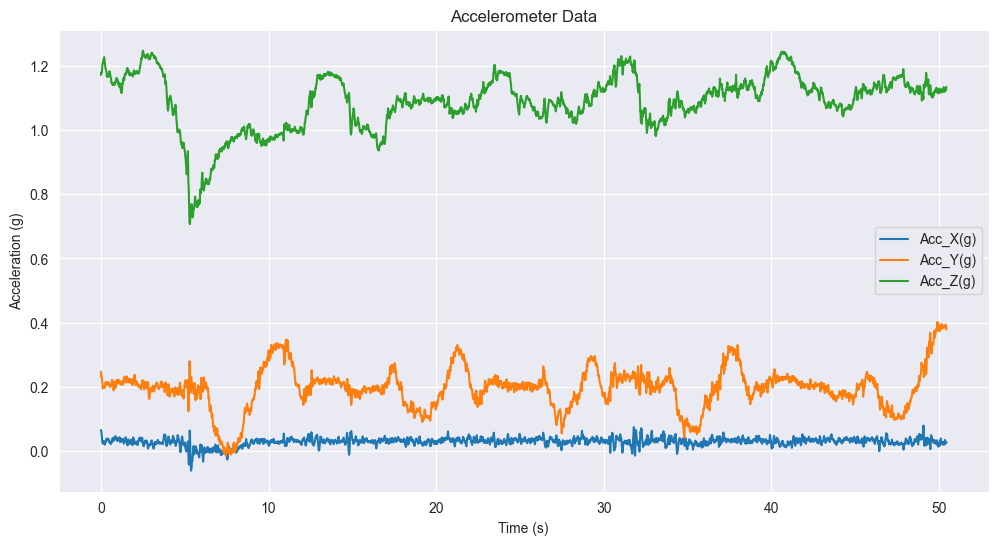

In [26]:
acc_df.plot(x='Time(s)', y=accl, title='Accelerometer Data', xlabel='Time (s)', ylabel='Acceleration (g)', figsize=(12, 6))

<Axes: title={'center': 'Gyroscope Data'}, xlabel='Time (s)', ylabel='Angular Velocity (D/s)'>

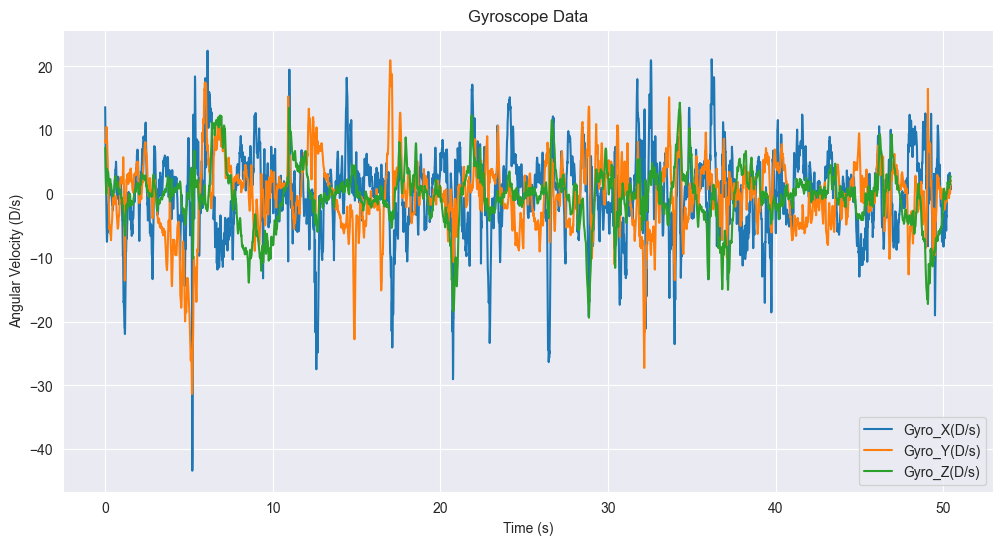

In [27]:
gyr_df.plot(x='Time(s)', y=gyro, title='Gyroscope Data', xlabel='Time (s)', ylabel='Angular Velocity (D/s)', figsize=(12, 6))

<Axes: title={'center': 'Magnetometer Data'}, xlabel='Time (s)', ylabel='Magnetic Field (μT)'>

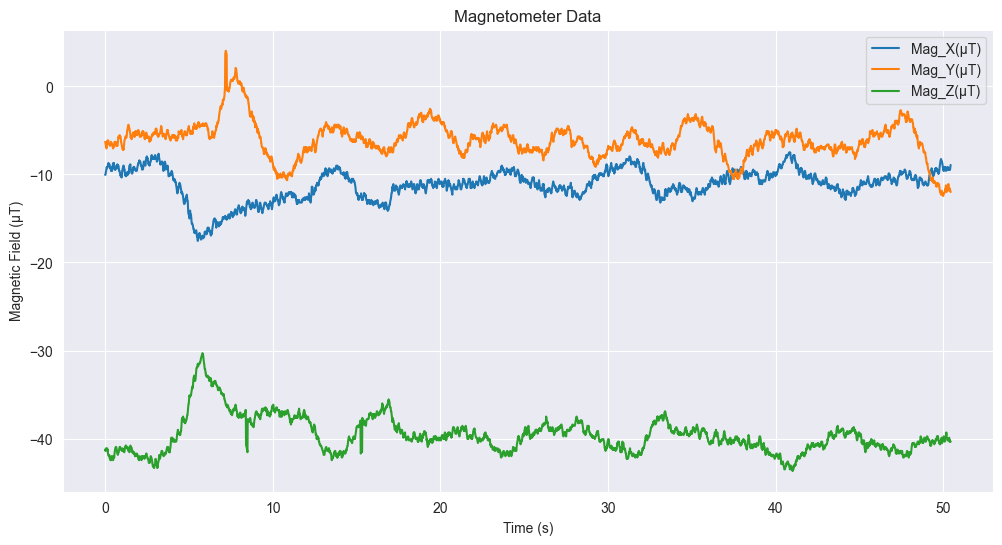

In [28]:
mag_df.plot(x='Time(s)', y=mag, title='Magnetometer Data', xlabel='Time (s)', ylabel='Magnetic Field (μT)', figsize=(12, 6))

Downsampled shapes:
Accelerometer: (5044, 4)
Gyroscope: (5044, 4)
Magnetometer: (5044, 4)


<Axes: title={'center': 'Downsampled Gyroscope Data'}, xlabel='Time (s)', ylabel='Angular velocity (Deg/s)'>

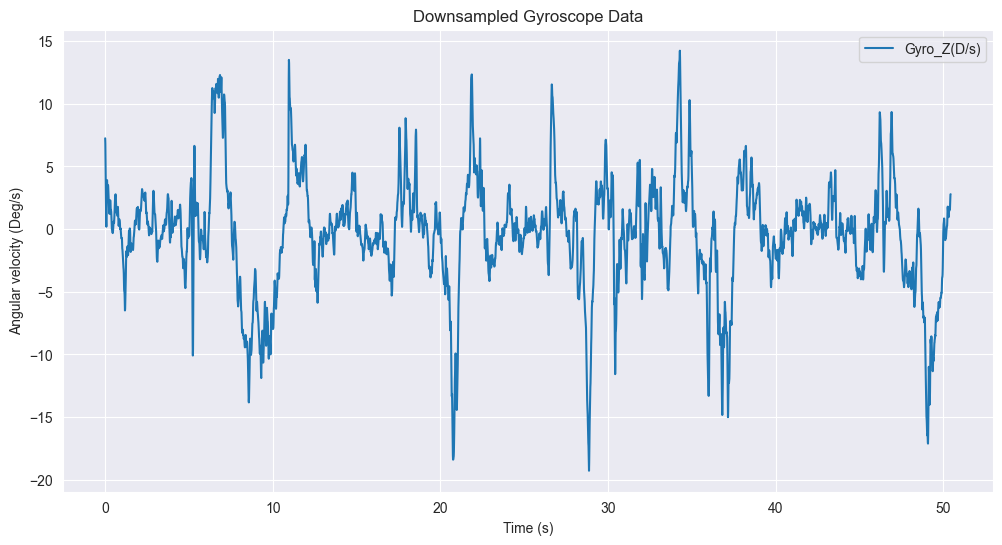

In [29]:
# Downsampling of data to 100 Hz
target_freq = 100  # Target frequency in Hz
def downsample_df(df, current_freq, target_freq):
    """
    :param df:
    :param current_freq:
    :param target_freq:
    :return:
    """
    step = int(current_freq / target_freq)
    return df.iloc[::step, :].reset_index(drop=True)

acc_df_ds = downsample_df(acc_df, acc_freq, target_freq)
gyr_df_ds = downsample_df(gyr_df, gyr_freq, target_freq)
mag_df_ds = downsample_df(mag_df, mag_freq, target_freq)

print("Downsampled shapes:")
print("Accelerometer:", acc_df_ds.shape)
print("Gyroscope:", gyr_df_ds.shape)
print("Magnetometer:", mag_df_ds.shape)


gyr_df_ds.plot(x='Time(s)', y='Gyro_Z(D/s)', title='Downsampled Gyroscope Data', xlabel='Time (s)', ylabel='Angular velocity (Deg/s)', figsize=(12, 6))

In [30]:
def apply_lowpass_filter(data, cutoff_freq, sampling_freq, order=4):
    """
    Apply a low-pass Butterworth filter to the data.

    Parameters:
    - data: DataFrame containing the signals to filter
    - cutoff_freq: Cutoff frequency in Hz
    - sampling_freq: Sampling frequency in Hz
    - order: Filter order (default=4)

    Returns:
    - Filtered data
    """
    nyquist_freq = sampling_freq / 2
    normalized_cutoff_freq = cutoff_freq / nyquist_freq
    b, a = signal.butter(order, normalized_cutoff_freq, btype='low')

    filtered_data = pd.DataFrame(index=data.index)
    filtered_data['Time(s)'] = data['Time(s)']

    # Filter each axis
    for column in data.columns:
        if column != 'Time(s)':  # Skip the time column
            filtered_data[column] = signal.filtfilt(b, a, data[column])

    return filtered_data


In [31]:
# # filtering parameters
# cutoff_frequency = 15  # Cutoff frequency in Hz
# sampling_frequency = acc_freq  # Sampling frequency in Hz
# filter_order = 4  # Filter order
# # Apply low-pass filter to downsampled data
# acc_df_filt = apply_lowpass_filter(acc_df_ds, cutoff_frequency, sampling_frequency, filter_order)
# gyr_df_filt = apply_lowpass_filter(gyr_df_ds, cutoff_frequency, sampling_frequency, filter_order)
#
# # Plot filtered accelerometer data
# acc_df_filt.plot(x='Time(s)', y=accl, title='Filtered Accelerometer Data', xlabel='Time (s)', ylabel='Acceleration (g)', figsize=(12, 6))
# gyr_df_filt.plot(x='Time(s)', y=gyro, title='Filtered Gyroscope Data', xlabel='Time (s)', ylabel='Angular Velocity (D/s)', figsize=(12, 6))

In [32]:
acc_df_ds[accl] = acc_df_ds[accl] * 9.81  # g to m/s^2
gyr_df_ds[gyro] = gyr_df_ds[gyro] * (np.pi / 180)  # D/s to rad/s

# rename columns again for later use
accl = ['Acc_X(m/s^2)', 'Acc_Y(m/s^2)', 'Acc_Z(m/s^2)']
gyro = ['Gyro_X(rad/s)', 'Gyro_Y(rad/s)', 'Gyro_Z(rad/s)']
# rename the columns to make access easier
acc_df_ds.columns = ['Time(s)'] + accl
gyr_df_ds.columns = ['Time(s)'] + gyro


[[ 12.26977129   0.49755454 163.05102217]
 [ 11.34009564  12.63894113 164.2113131 ]
 [ 11.64798968  14.21295561 166.15297678]
 ...
 [  9.9373061   20.11849258 171.34024502]
 [  9.9420427   20.11884068 171.34518635]
 [  9.94671921  20.11923214 171.35005703]]


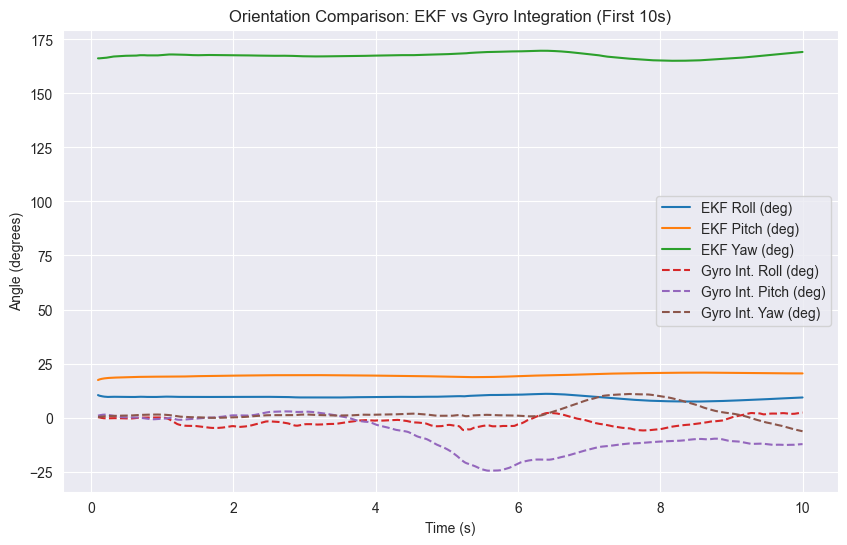

In [33]:
mag_df_ds[mag] = mag_df_ds[mag] * 1e-3  # μT to mT

acc_np = acc_df_ds[accl].to_numpy()
gyr_np = gyr_df_ds[gyro].to_numpy()
mag_np = mag_df_ds[mag].to_numpy()


ekf = EKF(gyr=gyr_np, acc=acc_np, mag=mag_np, frequency=mag_freq)

# Convert all quaternions to Euler angles (roll, pitch, yaw)
euler_angles = np.array([q2euler(q_) for q_ in ekf.Q])
euler_angles = np.degrees(euler_angles)

print(euler_angles)

# for comparison, calculate the orientation by integration of the gyroscope data
orientation = ['Orientation_X(deg)', 'Orientation_Y(deg)', 'Orientation_Z(deg)']
orientation_df = pd.DataFrame()
for i in range(len(gyro)):
    orientation_df[orientation[i]] = integrate.cumulative_trapezoid(gyr_df_ds[gyro[i]], gyr_df_ds['Time(s)'], initial=0)
# add time to orientation_df
orientation_df['Time(s)'] = gyr_df_ds['Time(s)']
# convert orientation from rad to deg
orientation_df[orientation] = np.degrees(orientation_df[orientation])

# identify index for first 10 seconds
# idx_10s = acc_df_ds['Time(s)'] <= 10

# remove first 0.1 seconds to avoid large initial transients
orientation_df = orientation_df[orientation_df['Time(s)'] >= 0.1].reset_index(drop=True)
euler_angles = euler_angles[acc_df_ds['Time(s)'] >= 0.1]

# identify index for first 10 seconds
idx_10s = orientation_df['Time(s)'] <= 10

# Plot the Euler angles and orientation for the first 10 seconds for comparison
# Plot the Euler angles and orientation for the first 10 seconds for comparison
plt.figure(figsize=(10, 6))
plt.plot(orientation_df['Time(s)'][idx_10s], euler_angles[idx_10s, 0], label='EKF Roll (deg)')
plt.plot(orientation_df['Time(s)'][idx_10s], euler_angles[idx_10s,1], label='EKF Pitch (deg)')
plt.plot(orientation_df['Time(s)'][idx_10s], euler_angles[idx_10s, 2], label='EKF Yaw (deg)')
plt.plot(orientation_df['Time(s)'][idx_10s], orientation_df['Orientation_X(deg)'][idx_10s], '--', label='Gyro Int. Roll (deg)')
plt.plot(orientation_df['Time(s)'][idx_10s], orientation_df['Orientation_Y(deg)'][idx_10s], '--', label='Gyro Int. Pitch (deg)')
plt.plot(orientation_df['Time(s)'][idx_10s], orientation_df['Orientation_Z(deg)'][idx_10s], '--', label='Gyro Int. Yaw (deg)')
plt.xlabel('Time (s)')
plt.ylabel('Angle (degrees)')
plt.title('Orientation Comparison: EKF vs Gyro Integration (First 10s)')
plt.legend()
plt.show()


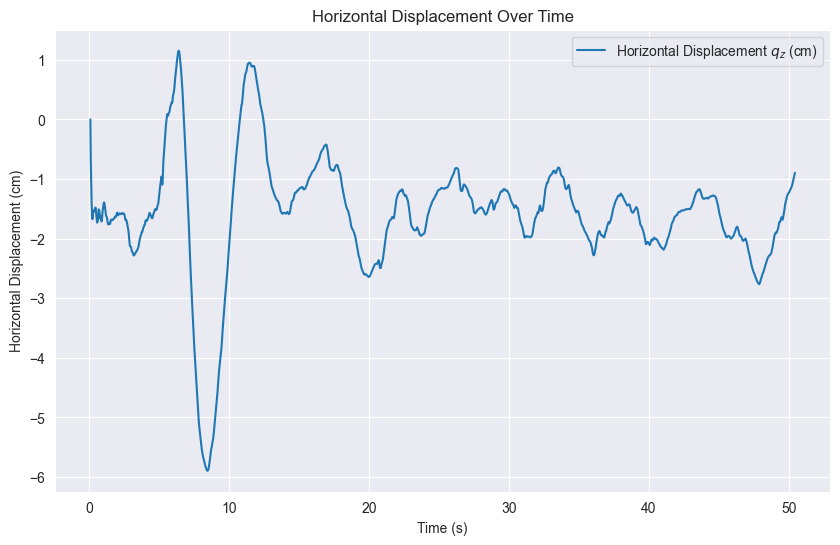

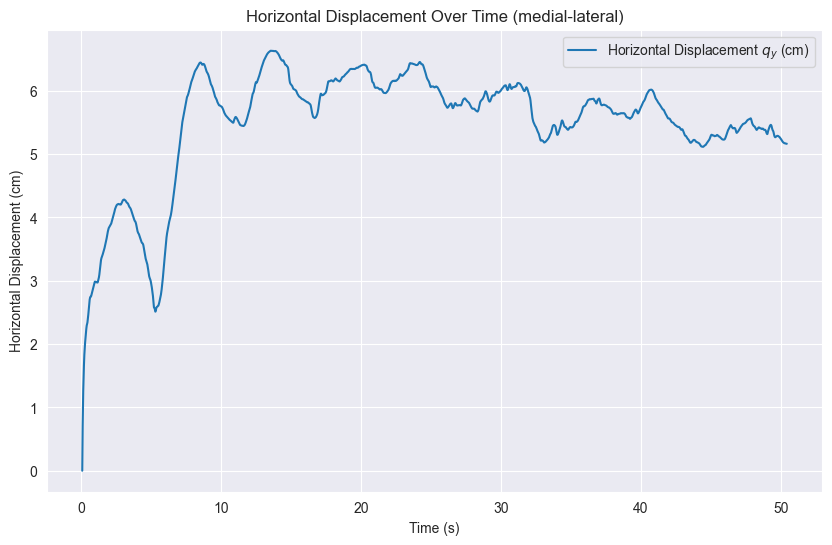

In [34]:
def calculate_horizontal_displacement_direct(fixed_leg_length_L, angle_series_degrees):
    """
    Calculates the time series of horizontal displacement (qx)
    using a fixed leg length (L) and the time series of the tilt angle (phi).

    Args:
        fixed_leg_length_L (float): The fixed leg length (L, hypotenuse),
                                    which is your initial maximum vertical displacement (q_y).
        angle_series_degrees (list or numpy array): The time series of angle phi in degrees.

    Returns:
        numpy array: The time series of horizontal displacements qx.
    """

    # Convert angle from degrees to radians for trigonometric functions
    angle_series_radians = np.radians(angle_series_degrees)
    # Formula: qx = L * sin(phi)
    horizontal_displacements_qx = fixed_leg_length_L * np.sin(angle_series_radians)

    return horizontal_displacements_qx

# --- Example Usage ---

# The fixed leg length L, which is defined as your initial vertical displacement (qy)
L_fixed = 1.14  # meters (Assumed from your previous input/context)

# Calculate the displacement series for anterior-posterior direction (using pitch angle)
displacements_ap = calculate_horizontal_displacement_direct(
    L_fixed,
    euler_angles[:, 0]  # Using pitch angle from EKF
)

# Calculate the displacement series for medial-lateral direction (using yaw angle)
displacements_ml = calculate_horizontal_displacement_direct(
    L_fixed,
    euler_angles[:, 1]  # Using yaw angle from EKF
)

# print(f"Fixed Leg Length (L): {L_fixed} m")
# print("-" * 40)

# # Organize results into a clear table
# print("Time | Angle $\phi$ (deg) | Horizontal Displacement $q_x$ (m)")
# print("-" * 45)
# for t, angle, qx in zip(orientation_df['Time(s)'][idx_10s], euler_angles[idx_10s, 1], displacements_ap):
#     print(f"{t:.1f}  | {angle:12.1f} | {qx:28.4f}")

# normalize the displacement to start at 0
displacements_ap -= displacements_ap[0]
# convert displacement ot cm
displacements_ap *= 100

displacements_ml -= displacements_ml[0]
displacements_ml *= 100

# plot horizontal displacement over time
plt.figure(figsize=(10, 6))
plt.plot(orientation_df['Time(s)'], displacements_ap, label='Horizontal Displacement $q_z$ (cm)')
plt.xlabel('Time (s)')
plt.ylabel('Horizontal Displacement (cm)')
plt.title('Horizontal Displacement Over Time')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(orientation_df['Time(s)'], displacements_ml, label='Horizontal Displacement $q_y$ (cm)')
plt.xlabel('Time (s)')
plt.ylabel('Horizontal Displacement (cm)')
plt.title('Horizontal Displacement Over Time (medial-lateral)')
plt.legend()
plt.show()


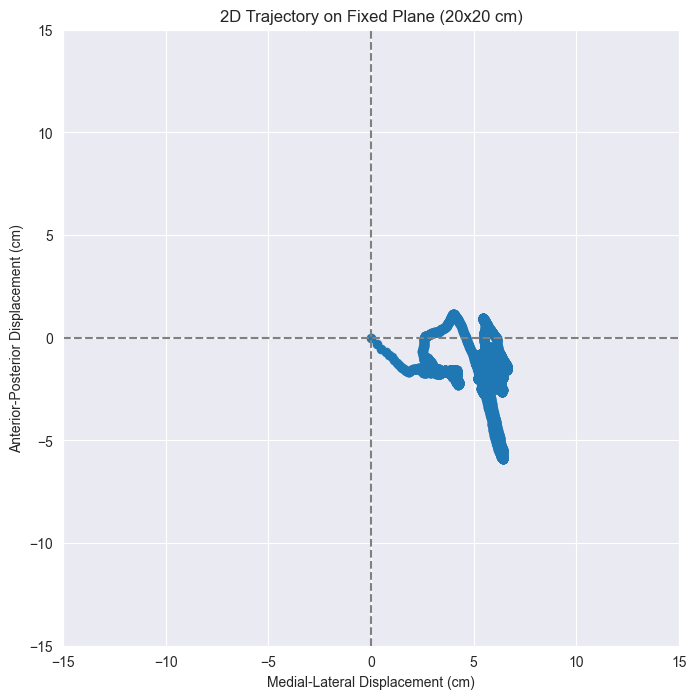

In [35]:
# mapping the displacement to a fixed 2D plane (20x20 cm)
plane_size_cm = 30  # cm
half_plane_size_cm = plane_size_cm / 2
scaling_factor = plane_size_cm / (2 * L_fixed * 100)  # Convert L_fixed to cm
# ensure the displacement does not exceed the plane size
displacements_ap_scaled = np.clip(displacements_ap, -half_plane_size_cm, half_plane_size_cm)
displacements_ml_scaled = np.clip(displacements_ml, -half_plane_size_cm, half_plane_size_cm)
# plot the 2D trajectory
plt.figure(figsize=(8, 8))
plt.plot(displacements_ml_scaled, displacements_ap_scaled, marker='o')
plt.xlim(-half_plane_size_cm, half_plane_size_cm)
plt.ylim(-half_plane_size_cm, half_plane_size_cm)
plt.xlabel('Medial-Lateral Displacement (cm)')
plt.ylabel('Anterior-Posterior Displacement (cm)')
plt.title('2D Trajectory on Fixed Plane (20x20 cm)')
plt.grid(True)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()